# MTSamples dataset - NLP Pipeline with ClinicalBERT Embeddings

This notebook demonstrates an NLP pipeline using the ClinicalBERT model for embedding clinical text. The goal is to classify the medical specialty associated with a transcription using a Logistic Regression classifier. 

### Pipeline Overview:
1. **Load and minimally preprocess the dataset:**
   - The MTSamples dataset is loaded and a minimal cleaning is applied on transcriptions.
2. **Split the data:**
   - The dataset is split into training and test sets while preserving the class distribution.
3. **Load ClinicalBERT model and tokenizer:**
   - The pipeline loads the `Bio_ClinicalBERT` model and its tokenizer from HuggingFace.
4. **Embed the texts:**
   - Each text is tokenized and passed through the model; we use mean pooling over token embeddings to obtain a fixed-size vector representation.
5. **Train the classifier:**
   - A Logistic Regression classifier is trained on the embeddings to predict the medical specialty.
6. **Evaluate the model:**
   - The performance is assessed using a classification report.


In [10]:
# STEP 0: Import Required Libraries

import os
import pandas as pd

import torch
from transformers import AutoTokenizer, AutoModel

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

import matplotlib.pyplot as plt

from tqdm import tqdm

print("Libraries imported successfully!")

Libraries imported successfully!


In [2]:
# STEP 1: Load and Minimally Preprocess the Dataset

# Get the current working directory
project_dir = os.getcwd()

# Construct the path to the CSV file (adjust if necessary)
mtsamples_path = os.path.join(project_dir, 'mtsamples.csv')

# Load the dataset into a pandas DataFrame
df = pd.read_csv(mtsamples_path)

def minimal_clean(text):
    """
    Perform minimal cleaning on the input text by stripping leading and trailing whitespace.
    """
    return str(text).strip()

# Apply the minimal cleaning function to the 'transcription' column
df['clean_text'] = df['transcription'].apply(minimal_clean)

# Drop rows with missing cleaned text or missing labels
df = df.dropna(subset=['clean_text', 'medical_specialty'])

# Extract the texts and labels
X = df['clean_text'].tolist()
y = df['medical_specialty']

print(f"Loaded {len(X)} samples.")

Loaded 4999 samples.


In [3]:
# STEP 2: Split the Data into Training and Testing Sets

# Stratified splitting to maintain class distribution
X_train_texts, X_test_texts, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

print(f"Training samples: {len(X_train_texts)}")
print(f"Testing samples: {len(X_test_texts)}")

Training samples: 3999
Testing samples: 1000


In [4]:
# STEP 3: Load ClinicalBERT Tokenizer and Model

# Specify the ClinicalBERT model name
model_name = "emilyalsentzer/Bio_ClinicalBERT"

# Load the tokenizer to convert text into token ids
tokenizer = AutoTokenizer.from_pretrained(model_name)

# Load the ClinicalBERT model to obtain text embeddings
model = AutoModel.from_pretrained(model_name)

# Set model to evaluation mode to disable dropout layers
model.eval()

# Move the model to GPU if available; otherwise, use CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

print("ClinicalBERT model and tokenizer loaded successfully.")

ClinicalBERT model and tokenizer loaded successfully.


In [5]:
# STEP 4: Embed Texts using ClinicalBERT

def embed_texts(texts, batch_size=16, max_len=128):
    """
    Embed a list of texts using ClinicalBERT. Each text is tokenized, passed through the model, 
    and the embeddings are obtained via mean pooling over the token embeddings.

    Parameters:
      texts (list): List of text strings to embed.
      batch_size (int): Number of texts to process in a batch.
      max_len (int): Maximum length for tokenization (for padding/truncation).
    
    Returns:
      list: List of embedding vectors (one per text).
    """
    embeddings = []
    
    # Process texts in batches
    for i in tqdm(range(0, len(texts), batch_size)):
        batch = texts[i:i+batch_size]
        
        # Tokenize the batch with padding and truncation
        encoded = tokenizer(batch, padding=True, truncation=True, max_length=max_len, return_tensors='pt')
        
        # Move the inputs to the selected device
        encoded = {k: v.to(device) for k, v in encoded.items()}
        
        # Perform inference without gradient calculations
        with torch.no_grad():
            output = model(**encoded)
        
        # Instead of using just the CLS token, perform mean pooling over token embeddings
        attention_mask = encoded['attention_mask'].unsqueeze(-1).expand(output.last_hidden_state.size()).float()
        masked_output = output.last_hidden_state * attention_mask
        mean_embeddings = masked_output.sum(dim=1) / attention_mask.sum(dim=1)
        
        # Convert embeddings to CPU and then to numpy arrays for further processing
        cls_embeds = mean_embeddings.cpu().numpy()
        embeddings.extend(cls_embeds)
    
    return embeddings

print("Embedding training data...")
X_train_vec = embed_texts(X_train_texts)

print("Embedding test data...")
X_test_vec = embed_texts(X_test_texts)

print(f"Embeddings created for {len(X_train_vec)} training samples and {len(X_test_vec)} test samples.")

Embedding training data...


100%|██████████| 250/250 [00:15<00:00, 16.02it/s]


Embedding test data...


100%|██████████| 63/63 [00:03<00:00, 16.68it/s]

Embeddings created for 3999 training samples and 1000 test samples.


Training Logistic Regression classifier...
Model training complete!
Evaluating the classifier...
Classification Report:
                                 precision    recall  f1-score   support

          Allergy / Immunology       0.00      0.00      0.00         1
                       Autopsy       1.00      1.00      1.00         1
                    Bariatrics       0.00      0.00      0.00         4
    Cardiovascular / Pulmonary       0.38      0.41      0.39        74
                  Chiropractic       0.00      0.00      0.00         3
    Consult - History and Phy.       0.16      0.06      0.09       103
    Cosmetic / Plastic Surgery       0.09      0.20      0.12         5
                     Dentistry       0.33      0.80      0.47         5
                   Dermatology       0.15      0.33      0.21         6
          Diets and Nutritions       0.00      0.00      0.00         2
             Discharge Summary       0.42      0.45      0.43        22
          ENT 

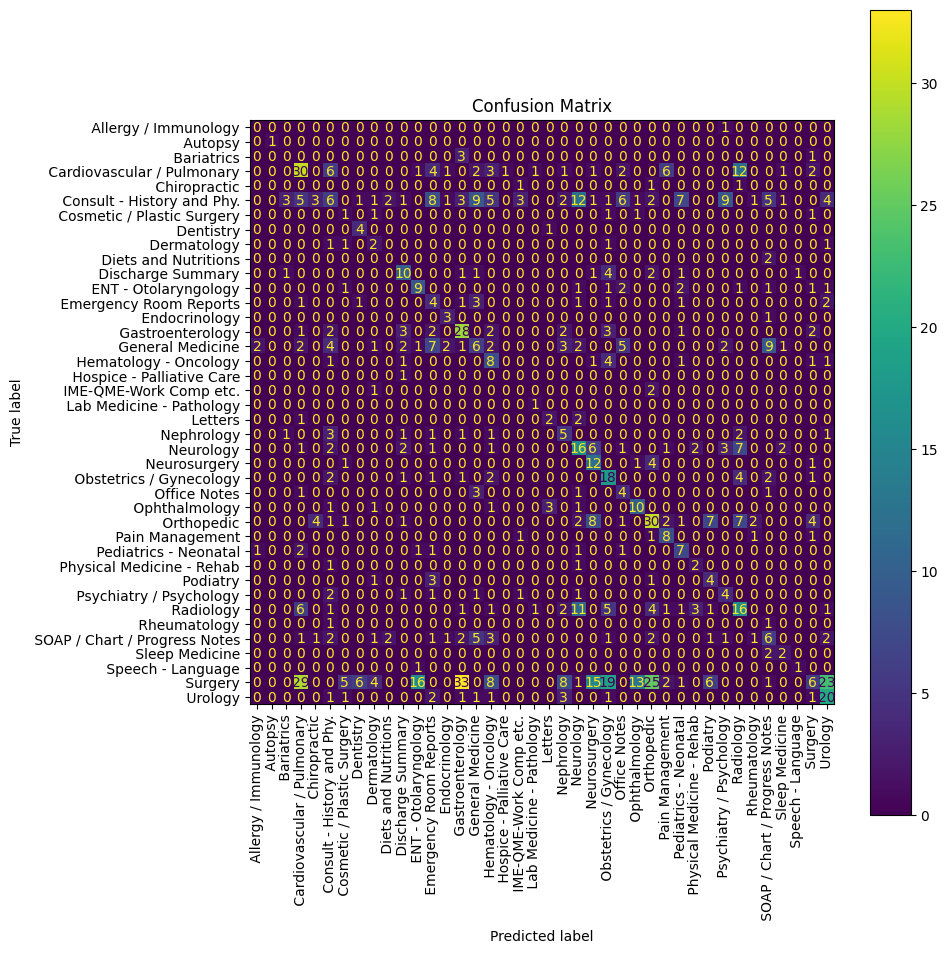

In [11]:
# STEP 5: Train the Logistic Regression Classifier and Evaluate

print("Training Logistic Regression classifier...")

# Initialize the classifier with balanced class weights to account for potential imbalances
clf = LogisticRegression(max_iter=1000, class_weight='balanced')

# Train the classifier using the embeddings from the training set
clf.fit(X_train_vec, y_train)

print("Model training complete!")

# Predict the labels for the test set
print("Evaluating the classifier...")
y_pred = clf.predict(X_test_vec)

# Generate and print a classification report
report = classification_report(y_test, y_pred)
print("Classification Report:\n", report)

# Generate a confusion matrix to show the model's performance across different classes
cm = confusion_matrix(y_test, y_pred, labels=clf.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=clf.classes_)

# Plot the confusion matrix with appropriate formatting
fig, ax = plt.subplots(figsize=(10, 10))
disp.plot(ax=ax, xticks_rotation=90)
plt.title('Confusion Matrix')
plt.tight_layout()
plt.show()

# The confusion matrix and the classification report provide insight into which medical specialties 
# are being classified well and where the classifier might be confusing one specialty for another.